In [1]:
#Import des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import custom_functions as cf
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, metrics, decomposition, preprocessing, manifold
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import random as rd

#Les options suivantes permettent d'afficher toutes les lignes et colonnes voulues lorsqu'on appelle la fonction print
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

#On importe le jeu de données
data = pd.read_csv('database_clients.csv')

#On jette un oeil à cette database
data.head()

,customer_unique_id,Recence_derniere_cmd,Nombre_commandes,Plusieurs_commandes,Montant_total,Montant_dernier,Mean_review_score,Prix_moyen_articles
0,0000366f3b9a7992bf8c76cfdf3221e2,115.0,1,0,129.90,129.90,5.0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,1,0,18.90,18.90,4.0,18.90
2,0000f46a3911fa3c0805444483337064,541.0,1,0,69.00,69.00,3.0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,325.0,1,0,25.99,25.99,4.0,25.99
4,0004aac84e0df4da2b147fca70cf8255,292.0,1,0,180.00,180.00,5.0,180.00


In [2]:
#On définit une fonction qui va simuler notre modèle de segmentation avec les données les plus anciennes,
#avant de le comparer avec des versions recalculées avec des données plus récentes
def simulation(data, colonnes, col_recence, recence_init, delta_t, k):
    
    #On initialise les dates
    time = recence_init
    dates = [recence_init - time]
    
    #On initialise les données
    X = data[data[col_recence] > time][colonnes]
    scaler = preprocessing.StandardScaler()
    scaler.fit(X)
    X_norm = scaler.transform(X)
    
    #On initialise le modèle k-means initial
    cls = cluster.KMeans(n_clusters=k, random_state=42)
    cls.fit(X_norm)
    
    #On initialise le score ARI obtenu (1 car on a qu'un seul modèle pour l'instant)
    scores = [1]
        
    while time > 0:
        #On incrémente et stocke le temps
        time = max(time - delta_t, 0)
        dates.append(recence_init - time)
        
        #On met a jour les données
        X = data[data[col_recence] > time][colonnes]
        scaler_temp = preprocessing.StandardScaler()
        scaler_temp.fit(X)
        #il faut en déduire deux jeux de données, avec deux scalings différents
        X_norm = scaler.transform(X)
        X_norm_temp = scaler_temp.transform(X)
        
        #On fit les deux modèles aux jeux de données respectifs
        cls_temp = cluster.KMeans(n_clusters=k, random_state=42)
        cls_temp.fit(X_norm_temp)
        cls_old = cls.predict(X_norm)
        
        #On les compare via l'ARI
        ari = metrics.adjusted_rand_score(cls_old, cls_temp.labels_)
        scores.append(ari)

    return dates, scores

In [3]:
#On liste les variables a utiliser
colonnes = ['Recence_derniere_cmd', 'Nombre_commandes', 'Montant_total', 'Mean_review_score', 'Prix_moyen_articles']
#La variable a utiliser pour identifier la date des commandes (on prend la dernière en date car seuls
#3% ont fait plusieurs commandes, ça ne devrait pas affecter significativement notre modèle)
col_recence = 'Recence_derniere_cmd'
#On commence la simulation a 20% de la fenêtre temporelle disponible pour nos données
recence_init = int(0.8*data['Recence_derniere_cmd'].max())
#On évalue ça tous les 7 jours
delta_t = 7
#On fera des k-means a 4 clusters
k = 4

#On lance la simulation, en récupérant les résultats
(dates, scores) = simulation(data, colonnes, col_recence, recence_init, delta_t, k)

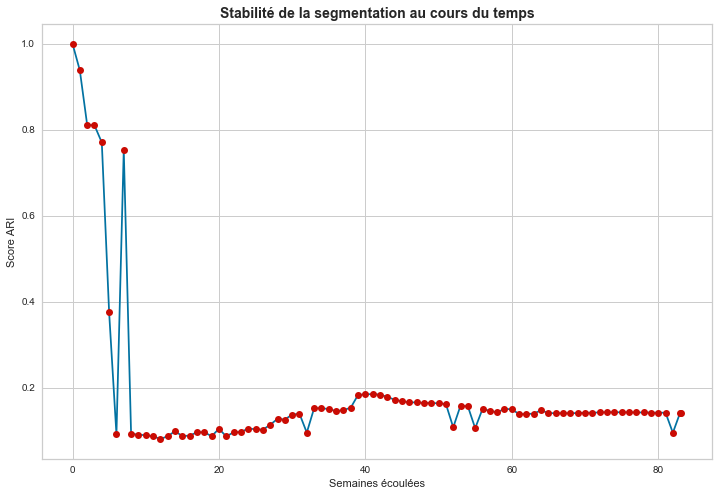

In [4]:
#On va convertir les durées en semaines pour plus de lisibilité
semaines = [t/7. for t in dates]
#On affiche l'évolution de l'ARI au cours de notre simulation
plt.figure(figsize=(12, 8))
plt.plot(semaines, scores, 'b', semaines, scores, 'ro')
plt.xlabel('Semaines écoulées')
plt.ylabel('Score ARI')
plt.title('Stabilité de la segmentation au cours du temps', fontsize=14, fontweight='bold')
plt.show()

Si on considère qu'un ARI en-dessous de $0,8$ est un bon indicateur de l'obsoléscence du modèle, alors ce graphique indique qu'il vaut mieux mettre à jour la segmentation proposée au bout de 4 à 5 semaines, soit une fois par mois. Néanmoins on peut questionner le choix de date initiale dans cette simulation.

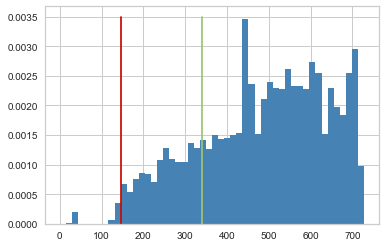

In [5]:
#On affiche la répartition de la variable de Récence, pour voir si le choix de date initiale de la simulation est pertinent
Max = data['Recence_derniere_cmd'].max()
date = Max - data[col_recence]
recence_init = int(0.8*Max)
recence_init_bis = data['Recence_derniere_cmd'].quantile(q=0.8)
plt.hist(date, bins=50, color='steelblue', density=True, edgecolor='none')
plt.plot([Max - recence_init]*2, [0,0.0035],'r')
plt.plot([Max - recence_init_bis]*2, [0,0.0035],'g')
plt.show()

Le choix de démarrer la simulation à 20% de notre fenêtre temporel est dicutable ici, car on ne dispose que de très peu de données, sûrement trop peu pour qu'elles soient représentatives de toute la clientèle. Nous allons essayer de considérer la date à partir de laquelle nous disposons de 20% de nos données, ce qui laissera environ un an de simulation.

In [6]:
#On lance la simulation, mais en utilisant cette fois la seconde date initiale, celle où l'on dispose de 20% de nos données
(dates_bis, scores_bis) = simulation(data, colonnes, col_recence, recence_init_bis, delta_t, k)

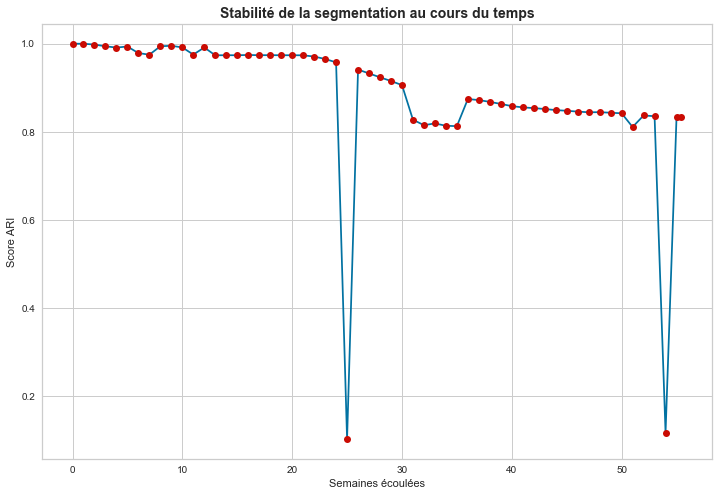

In [7]:
semaines_bis = [t/7. for t in dates_bis]
plt.figure(figsize=(12, 8))
plt.plot(semaines_bis, scores_bis, 'b', semaines_bis, scores_bis, 'ro')
plt.xlabel('Semaines écoulées')
plt.ylabel('Score ARI')
plt.title('Stabilité de la segmentation au cours du temps', fontsize=14, fontweight='bold')
plt.show()

Le résultat est bien plus concluant : notre modèle semble parfaitement stable lors de l'ajout de nouvelles données, devant être entraîné à nouveau toutes les 20 à 25 semaines, soit 4 à 5 mois.